# Install required packages

In [1]:
%pip install -r requirements.txt

  Cloning git://github.com/guyrosin/transformers.git (to revision fillmask_pipeline_fix) to /private/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/pip-install-bd2tmutp/transformers_fc6b9865fb2a4c6ea6146f633543a484
  Running command git clone --filter=blob:none --quiet git://github.com/guyrosin/transformers.git /private/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/pip-install-bd2tmutp/transformers_fc6b9865fb2a4c6ea6146f633543a484
  fatal: unable to connect to github.com:
  github.com[0: 140.82.121.4]: errno=Operation timed out

  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet git://github.com/guyrosin/transformers.git /private/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/pip-install-bd2tmutp/transformers_fc6b9865fb2a4c6ea6146f633543a484 did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone -

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import transformers


/Users/carstenschnober/opt/anaconda3/envs/SoS/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [3]:
from pathlib import Path


DATA_DIR = Path.home() / "Documents" / "SemanticsOfSustainability" / "data" / "Joris"
assert DATA_DIR.is_dir()


In [4]:
from datetime import datetime
import logging
from pandas._libs.tslibs.timestamps import Timestamp


def to_decade(date) -> str:
    if isinstance(date, Timestamp):
        return to_decade(date.year)
    elif isinstance(date, int):
        start = int(date / 10) * 10
        return f"{start} - {start+10}"
    elif isinstance(date, str):
        return to_decade(pd.to_datetime(date))
    else:
        raise RuntimeError(f"Invalid date: '{date}'")


def date_to_string(dt) -> str:
    if isinstance(dt, Timestamp):
        return str(dt.date())
    elif isinstance(dt, str):
        return dt
    else:
        raise RuntimeError(f"Invalid date: '{dt}'")


## ANP

In [5]:
ANP_DIR = DATA_DIR / "ANP" / "CleanFiles_perYear"
assert ANP_DIR.is_dir()


In [6]:
from tqdm import tqdm


FILE_GLOB = "ANP_19[0-9][0-9].csv.gz"
ENCODING = "iso8859_15"

anp = pd.concat(
    tqdm(
        (
            pd.read_csv(
                f, compression="gzip", sep=";", encoding=ENCODING, parse_dates=["date"]
            ).dropna(subset="content")
            for f in ANP_DIR.glob(FILE_GLOB)
        ),
        total=len(list(ANP_DIR.glob(FILE_GLOB))),
        unit="file",
        desc="Reading",
    ),
    ignore_index=True,
).convert_dtypes()
anp["decade"] = anp["year"].apply(to_decade)


anp


Reading: 100%|██████████| 48/48 [00:16<00:00,  2.93file/s]


,filename,content,date,year,month,day,issue,decade
0,anp_1952_01_01_10_ocr.xml,Red.: Datum: veldman 1-1-52 Tijd: 13 ttt^....,1952-01-01,1952,1,1,10,1950 - 1960
1,anp_1952_01_01_11_ocr.xml,Red. Datum: Tijd: Onderwerp: veltmeijer 1...,1952-01-01,1952,1,1,11,1950 - 1960
2,anp_1952_01_01_12_ocr.xml,/3* Red. Datum: Tijd: Onderwerp: veltmei...,1952-01-01,1952,1,1,12,1950 - 1960
3,anp_1952_01_01_13_ocr.xml,Red.: Datum: Tijd: Onderwerp: veltmeijer ...,1952-01-01,1952,1,1,13,1950 - 1960
4,anp_1952_01_01_14_ocr.xml,Red.: Datum: Tijd: Onderwerp: mallon 1-1-...,1952-01-01,1952,1,1,14,1950 - 1960
...,...,...,...,...,...,...,...,...
1474644,anp_1973_12_31_96_ocr.xml,Red.: Datum: Tijd: Onderwerp: kreek 31. 12. 7...,1973-12-31,1973,12,31,96,1970 - 1980
1474645,anp_1973_12_31_97_ocr.xml,Red.: Datum: Tijd: Onderwerp: kuy 31-12-...,1973-12-31,1973,12,31,97,1970 - 1980
1474646,anp_1973_12_31_98_ocr.xml,Red. Datum: Tijd: Onderwerp: kreek 31. 12...,1973-12-31,1973,12,31,98,1970 - 1980
1474647,anp_1973_12_31_99_ocr.xml,Red. Datum: Tijd: Onderwerp: zijl 31-12-...,1973-12-31,1973,12,31,99,1970 - 1980


Text(0, 0.5, 'Number of Documents')

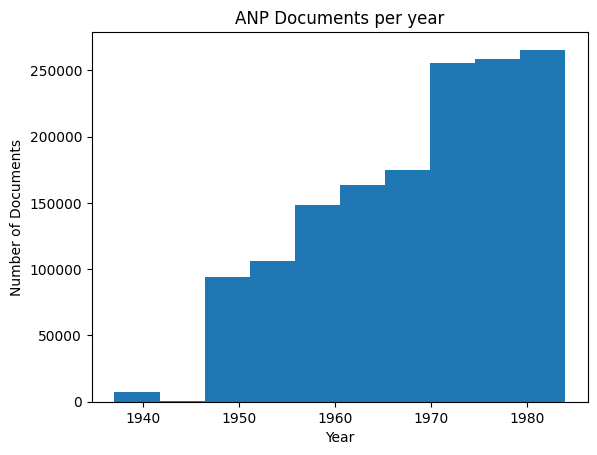

In [7]:
plt.hist(anp.year, label="Year")
plt.title("ANP Documents per year")
plt.xlabel("Year")
plt.ylabel("Number of Documents")


Text(0.5, 0, 'Number of Characters')

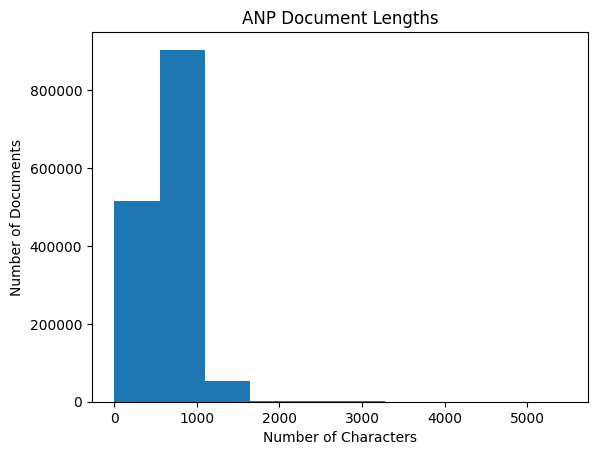

In [8]:
plt.hist(anp.content.str.len())
plt.title("ANP Document Lengths")
plt.ylabel("Number of Documents")
plt.xlabel("Number of Characters")


## StatenGeneraal

In [9]:
SG_DIR = DATA_DIR / "StatenGeneraal"

assert SG_DIR.is_dir()

SG_GLOB = "StatenGeneraal_[12][890][0-9][0-9].csv.gz"

In [10]:
from tqdm import tqdm

ENCODING = "iso8859_15"


staten_generaal = pd.concat(
    tqdm(
        (
            pd.read_csv(
                f, compression="gzip", sep=";", encoding=ENCODING, parse_dates=["date"]
            ).dropna(subset="Content")
            for f in SG_DIR.glob(SG_GLOB)
        ),
        total=len(list(SG_DIR.glob(SG_GLOB))),
        unit="file",
        desc="Reading",
    ),
    ignore_index=True,
).convert_dtypes()

staten_generaal


Reading: 100%|██████████| 205/205 [01:30<00:00,  2.26file/s]


,Unnamed: 0,date,RecId,title,type,description,year,Content,ocr_link,pages,chamber,leg_period,speakers
0,144302,1976-01-02,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Kamerstuk,Rijksbegroting voor het dienstjaar 1976. Defensie,BRIEF VAN DE MINISTER VAN DEFENSIE,1976,Tweede Kamer der Staten-Generaal 2 Zitting 197...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,1,StatenGeneraal,<NA>,<NA>
1,144303,1976-01-02,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Kamerstuk,Wijziging Liquidatiewet invaliditeitswetten,KONINKLIJKE BOODSCHAP,1976,Tweede Kamer der Staten-Generaal 2 Zitting 197...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,1,StatenGeneraal,<NA>,<NA>
2,144304,1976-01-02,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Kamerstuk,"Naturalisatie van Bakarbessy, Jacobus Hermanus...",KONINKLIJKE BOODSCHAP,1976,Tweede Kamer der Staten-Generaal 2 Zitting 197...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,1,StatenGeneraal,<NA>,<NA>
3,144305,1976-01-05,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Kamerstuk,Wijziging van de Kleuteronderwijswet (Stb. 197...,VERSLAG,1976,Tweede Kamer der Staten-Generaal 2 Zitting 197...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,"1, 2, 3",StatenGeneraal,<NA>,<NA>
4,144306,1976-01-05,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Kamerstuk,Uitvoering van artikel 15 van de Comptabilitei...,NOTA NAAR AANLEIDING VAN HET VERSLAG,1976,Tweede Kamer der Staten-Generaal Zitting 1975-...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,"1, 2, 3",StatenGeneraal,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187141,108,1857-12-02 00:00:00,nl.proc.sgd.d.185718580000114,Handelingen Tweede Kamer 1857-1858 02 december...,Verbatim Proceedings,<NA>,1857,65ste vel. â 227 â Tweede Kamer.ZITTIN G V...,<NA>,<NA>,TweedeKamer,1857-1858,"nl.m.00697: mp, de heer: Kien; nl.m.00473: cha..."
187142,109,1857-12-07 00:00:00,nl.proc.sgd.d.185718580000115,Handelingen Tweede Kamer 1857-1858 07 december...,Verbatim Proceedings,<NA>,1857,G7stc vel. â 235 TV Tweede Kamer.27ste IIfT1...,<NA>,<NA>,TweedeKamer,1857-1858,"nl.m.00855: mp, De heer: baron van Lynden; nl...."
187143,110,1857-12-10 00:00:00,nl.proc.sgd.d.185718580000116,Handelingen Tweede Kamer 1857-1858 10 december...,Verbatim Proceedings,<NA>,1857,68ste vel. 237 â Tweede Kamer.Z1TITN G VAN D...,<NA>,<NA>,TweedeKamer,1857-1858,"nl.m.02118: government, minister: Vrolik; nl.m..."
187144,111,1857-12-11 00:00:00,nl.proc.sgd.d.185718580000117,Handelingen Tweede Kamer 1857-1858 11 december...,Verbatim Proceedings,<NA>,1857,73ste vel. â 255 â Tweede Kamer.LXf. liuit...,<NA>,<NA>,TweedeKamer,1857-1858,"nl.m.00918: mp, De heer: Meijlink; nl.m.01557:..."


Text(0, 0.5, 'Number of Documents')

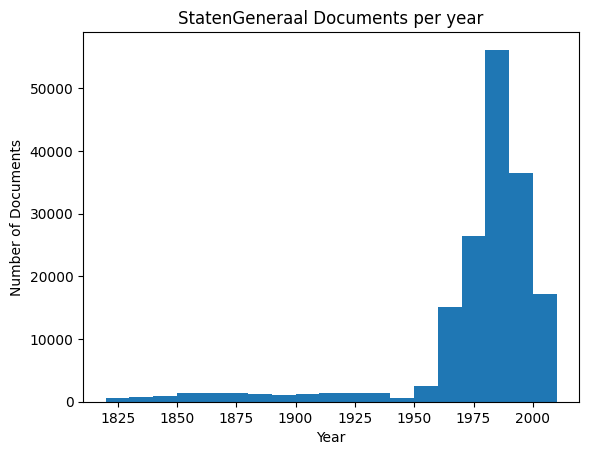

In [11]:
plt.hist(staten_generaal.year, label="Year", bins=range(1820, 2020, 10))
plt.title("StatenGeneraal Documents per year")
plt.xlabel("Year")
plt.ylabel("Number of Documents")


Text(0.5, 0, 'Number of Characters')

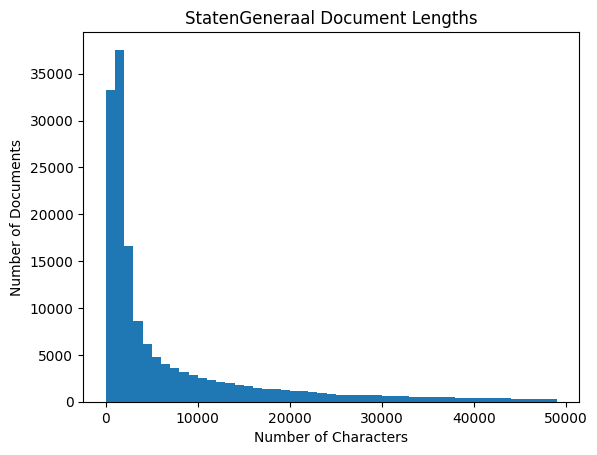

In [12]:
plt.hist(staten_generaal.Content.str.len(), bins=range(0, 50000, 1000))
plt.title("StatenGeneraal Document Lengths")
plt.ylabel("Number of Documents")
plt.xlabel("Number of Characters")


## Newspapers (Delpher)

In [13]:
DELPHER_DIR = DATA_DIR / "Delpher" / "RawFiles"

assert DELPHER_DIR.is_dir()

### Volkskrant

In [14]:
VOLKSKRANT_DIR = DELPHER_DIR / "Volkskrant"

assert VOLKSKRANT_DIR.is_dir()

In [15]:
VOLKSKRANT_GLOB = "Volkskrant_1[0-9][0-9][0-9].csv.gz"

volkskrant = pd.concat(
    tqdm(
        (
            pd.read_csv(
                f, compression="gzip", sep=";", encoding=ENCODING, parse_dates=["date"]
            ).dropna(subset="Content")
            for f in VOLKSKRANT_DIR.glob(VOLKSKRANT_GLOB)
        ),
        total=len(list(VOLKSKRANT_DIR.glob(VOLKSKRANT_GLOB))),
        unit="file",
        desc="Reading Volkskrant",
    )
).convert_dtypes()

volkskrant


Reading Volkskrant: 100%|██████████| 77/77 [02:20<00:00,  1.82s/file]


,Unnamed: 0,Content,RecId,article_tit,date,genre,month,newspaper,year
0,0,TWEE AMERIKANEN MOETEN GIJZELINGSDRAMA MET DOO...,ddd:010879303:mpeg21:a0001,<NA>,1984-12-10,artikel,12,Volkskrant,1984
1,1,RSV-top reageert voorlopig niet op enquÃªterap...,ddd:010879303:mpeg21:a0002,<NA>,1984-12-10,artikel,12,Volkskrant,1984
2,2,Goedkope boter ook net Pasen te koop Jttj-VERS...,ddd:010879303:mpeg21:a0003,<NA>,1984-12-10,artikel,12,Volkskrant,1984
3,3,Rotterdam krijgt kabelkrant OTTERDAM â De Av...,ddd:010879303:mpeg21:a0004,<NA>,1984-12-10,artikel,12,Volkskrant,1984
4,4,Is Gijs wijs? 'le Qt betekent het dat de reger...,ddd:010879303:mpeg21:a0005,<NA>,1984-12-10,artikel,12,Volkskrant,1984
...,...,...,...,...,...,...,...,...,...
84950,84950,KEERZIJDE Bord Tandakken naar de beelden van N...,ddd:010879915:mpeg21:a0208,<NA>,1981-08-31,artikel,8,Volkskrant,1981
84951,84951,"Volk Het volk betaalt belasting, mede om het b...",ddd:010879915:mpeg21:a0209,<NA>,1981-08-31,artikel,8,Volkskrant,1981
84952,84952,Toilet Op het tweejaarlijkse congres van de So...,ddd:010879915:mpeg21:a0210,<NA>,1981-08-31,artikel,8,Volkskrant,1981
84953,84953,Volksmond Van alle sportorganisaties was het k...,ddd:010879915:mpeg21:a0211,<NA>,1981-08-31,artikel,8,Volkskrant,1981


Text(0, 0.5, 'Number of Documents')

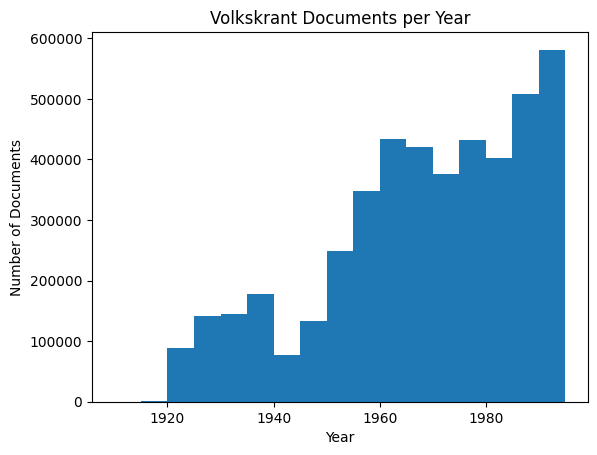

In [16]:
plt.hist(volkskrant.year, label="Year", bins=range(1910, 2000, 5))
plt.title("Volkskrant Documents per Year")
plt.xlabel("Year")
plt.ylabel("Number of Documents")

Text(0.5, 0, 'Number of Characters')

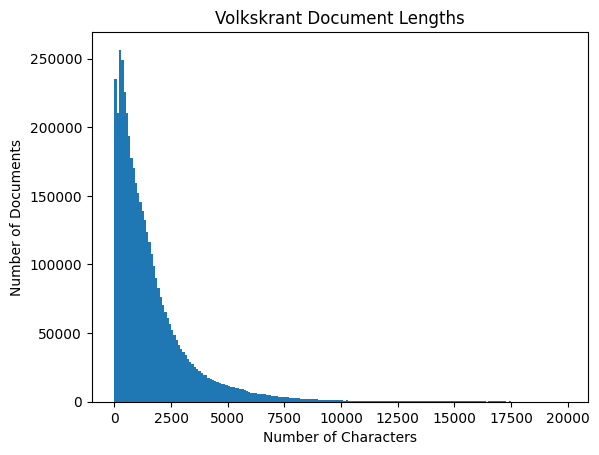

In [17]:
plt.hist(volkskrant.Content.str.len(), bins=range(0, 20000, 100))
plt.title("Volkskrant Document Lengths")
plt.ylabel("Number of Documents")
plt.xlabel("Number of Characters")

# Load Model

In [18]:
MODEL_NAME = "DTAI-KULeuven/robbertje-1-gb-non-shuffled"  # NL MODEL TODO: is the model trained on lowercased data?

MODEL_MAX_LENGTH = 512


In [19]:
from transformers import AutoTokenizer, RobertaModel


tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, model_max_length=MODEL_MAX_LENGTH, truncation=True
)
model = RobertaModel.from_pretrained(MODEL_NAME)


Some weights of the model checkpoint at DTAI-KULeuven/robbertje-1-gb-non-shuffled were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at DTAI-KULeuven/robbertje-1-gb-non-shuffled and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this mode

# Find Contexts

In [20]:
TERM = "mobiel"


In [21]:
term_token_ids = tokenizer(TERM)["input_ids"]
print(term_token_ids)

print(tokenizer.convert_ids_to_tokens(term_token_ids))


[0, 33388, 2]
['<s>', 'mobiel', '</s>']


## ANP

In [24]:
from src.context import Context

anp_contexts = []

anp_term_rows = anp.loc[anp.content.str.contains(TERM)]

for index, row in tqdm(anp_term_rows.iterrows(), total=len(anp_term_rows), unit="row"):
    anp_contexts.extend(
        Context.contexts(
            row.content,
            TERM,
            MODEL_MAX_LENGTH,
            model,
            tokenizer,
            {"date": row.date, "source": row.filename},
        )
    )

print(f"Rows containing '{TERM}' in ANP: {len(anp_term_rows)}")
print(f"Contexts found for '{TERM}' in ANP: {len(anp_contexts)}")


ModuleNotFoundError: No module named 'src'

In [ ]:
anp_term_rows


,filename,content,date,year,month,day,issue,decade
546,anp_1952_01_08_9_ocr.xml,Red.: Korp. Datum: 8 Jan.' 52 Tijd: Onde...,1952-08-01,1952,1,8,9,1950 - 1960
2398,anp_1952_02_02_14_ocr.xml,Red.: vm Datum: Tijd: 2. febr. ^ Onder...,1952-02-02,1952,2,2,14,1950 - 1960
3826,anp_1952_02_20_39_ocr.xml,Red.: Romijn Datum: 20 Febr. Tijd: 18. 00...,1952-02-20,1952,2,20,39,1950 - 1960
4510,anp_1952_02_29_31_ocr.xml,Red.: Datum: Tijd: Onderwerp: Korp. 29 Fe...,1952-02-29,1952,2,29,31,1950 - 1960
4524,anp_1952_02_29_44_ocr.xml,Red. Datum: Tijd: ) nderwerp: veltmeijer ...,1952-02-29,1952,2,29,44,1950 - 1960
...,...,...,...,...,...,...,...,...
1474125,anp_1973_12_28_150_ocr.xml,Red.: Datum: mon 28+12-73 Tijd: as^^^y On...,1973-12-28,1973,12,28,150,1970 - 1980
1474189,anp_1973_12_28_71_ocr.xml,"Red.: ^^ Datum: Tijd: Q^*"" ^"" ^^' mon 28*12-7...",1973-12-28,1973,12,28,71,1970 - 1980
1474286,anp_1973_12_29_1_ocr.xml,"Red.: Datum: Tijd: Onderwerp: , duljv 29...",1973-12-29,1973,12,29,1,1970 - 1980
1474341,anp_1973_12_29_6_ocr.xml,Red.: bkr Datum: Tijd: 29-12-73 g.. n. 7-...,1973-12-29,1973,12,29,6,1970 - 1980


Text(0, 0.5, 'Number of Documents')

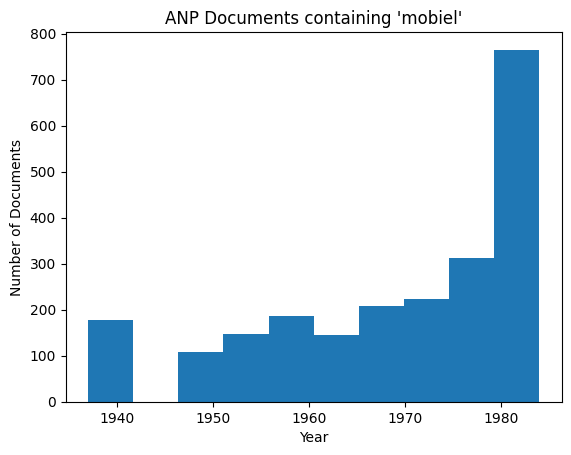

In [ ]:
plt.hist(anp_term_rows.year)
plt.title(f"ANP Documents containing '{TERM}'")
plt.xlabel("Year")
plt.ylabel("Number of Documents")


Text(0, 0.5, 'Number of Documents')

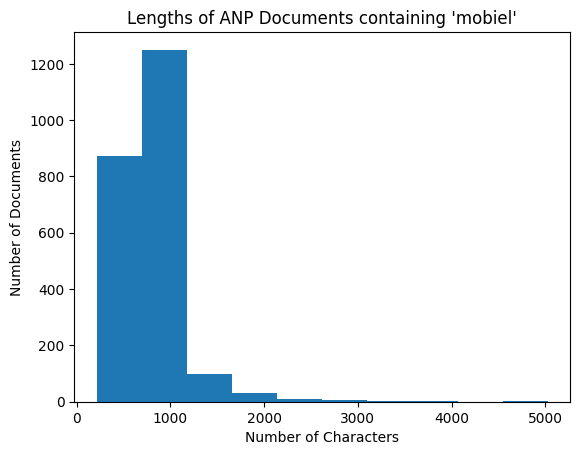

In [ ]:
plt.hist(anp_term_rows.content.str.len())
plt.title(f"Lengths of ANP Documents containing '{TERM}'")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Documents")


## Staten Generaal

In [ ]:
from tqdm import tqdm

sg_contexts = []
sg_term_rows = staten_generaal.loc[staten_generaal.Content.str.contains(TERM)]

for index, row in tqdm(sg_term_rows.iterrows(), total=len(sg_term_rows), unit="row"):
    sg_contexts.extend(
        Context.contexts(
            row.Content,
            TERM,
            MODEL_MAX_LENGTH,
            model,
            tokenizer,
            {"date": row.date, "source": row.RecId},
        )
    )
print(f"Rows containing '{TERM}' in Staten Generaal: {len(sg_term_rows)}")
print(f"Contexts found for '{TERM}' in Staten Generaal: {len(sg_contexts)}")


100%|██████████| 4814/4814 [00:12<00:00, 392.68row/s]

Rows containing 'mobiel' in Staten Generaal: 4814
Contexts found for 'mobiel' in Staten Generaal: 1710


In [ ]:
sg_term_rows


,Unnamed: 0,date,RecId,title,type,description,year,Content,ocr_link,pages,chamber,leg_period,speakers
39,144347,1976-01-15,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Kamerstuk,Gebeurtenissen rond de treinkaping te Beilen e...,VERSLAG,1976,Tweede Kamer der Staten-Generaal Zitting 1975-...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...",StatenGeneraal,<NA>,<NA>
69,144382,1976-01-20,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Handelingen,Handelingen Tweede Kamer 1975-1976 20 januari ...,Handelingen Tweede Kamer 1975-1976 20 januari ...,1976,37ste Vergadering Voorzitter: Vondeling Tegenw...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,"2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258...",StatenGeneraal,<NA>,<NA>
174,144507,1976-02-03,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Kamerstuk,Kwantitatieve beperkingen in de olieaanvoer,VERSLAG VAN OPENBARE GESPREKKEN,1976,Tweede Kamer der Staten-Generaal 2 Zitting 197...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...",StatenGeneraal,<NA>,<NA>
248,144590,1976-02-12,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Handelingen,Handelingen Tweede Kamer 1975-1976 12 februari...,Handelingen Tweede Kamer 1975-1976 12 februari...,1976,48ste Vergadering Voorzitter: Vondeling Tegenw...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,"2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806...",StatenGeneraal,<NA>,<NA>
293,144636,1976-02-18,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Handelingen,Handelingen Tweede Kamer 1975-1976 18 februari...,Handelingen Tweede Kamer 1975-1976 18 februari...,1976,50ste Vergadering Voorzitter: Vondeling Tegenw...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,"2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920...",StatenGeneraal,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...
186945,208,1957-12-03 00:00:00,nl.proc.sgd.d.195719580000010,Handelingen Eerste Kamer 1957-1958 03 december...,Verbatim Proceedings,<NA>,1957,Ingekomen stukken 9de vergadering â 3 decemb...,<NA>,<NA>,EersteKamer,1957-1958,"nl.m.00661: chair, voorzitter: Jonkman; nl.m.0..."
186964,227,1957-11-12 00:00:00,nl.proc.sgd.d.195719580000251,Handelingen Tweede Kamer 1957-1958 12 november...,Verbatim Proceedings,<NA>,1957,Ingekomen stukken 16de vergadering - 12 novemb...,<NA>,<NA>,TweedeKamer,1957-1958,"nl.m.01559: government, minister: Witte; nl.m...."
186973,236,1957-12-03 00:00:00,nl.proc.sgd.d.195719580000260,Handelingen Tweede Kamer 1957-1958 03 december...,Verbatim Proceedings,<NA>,1957,Ingekomen stukken 25ste vergadering â 3 dece...,<NA>,<NA>,TweedeKamer,1957-1958,"nl.m.00738: chair, voorzitter: Kortenhorst; nl..."
186998,261,1957-11-20 00:00:00,nl.proc.sgd.d.195719580001275,Handelingen Tweede Kamer 1957-1958 20 november...,Verbatim Proceedings,<NA>,1957,Vaststelling hoofdstuk IV (Justitie) 1958VERGA...,<NA>,<NA>,TweedeKamer,1957-1958,"nl.m.01492: mp, De heer: Vrolijk; nl.m.00056: ..."


Text(0, 0.5, 'Number of Documents')

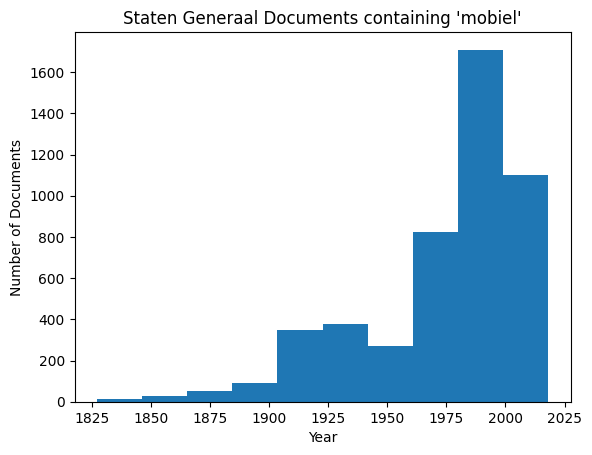

In [ ]:
plt.hist(sg_term_rows.year)
plt.title(f"Staten Generaal Documents containing '{TERM}'")
plt.xlabel("Year")
plt.ylabel("Number of Documents")


Text(0, 0.5, 'Number of Documents')

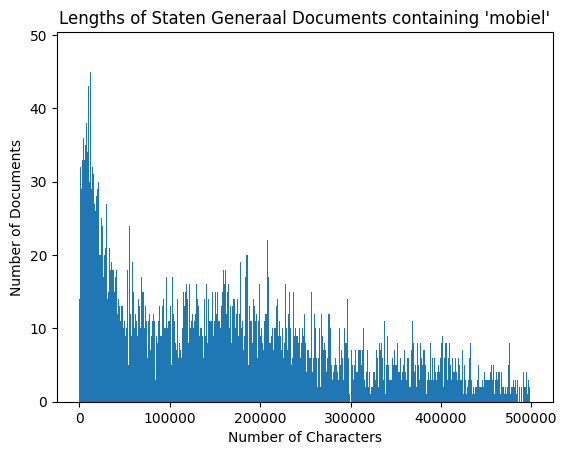

In [ ]:
plt.hist(sg_term_rows.Content.str.len(), bins=range(0, 500000, 1000))
plt.title(f"Lengths of Staten Generaal Documents containing '{TERM}'")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Documents")


## Volkskrant

In [ ]:
volkskrant_contexts = []
volkskrant_term_rows = volkskrant.loc[volkskrant.Content.str.contains(TERM)]

volkskrant_term_rows

,Unnamed: 0,Content,RecId,article_tit,date,genre,month,newspaper,year
530,530,Skireis Wallis ( 1500-3000 m.) januari: 10 dgn...,ddd:010879305:mpeg21:a0051,<NA>,1984-12-12,advertentie,12,Volkskrant,1984
728,728,< II I' ' 'âfitâ IâIII9MIMJLMIiI-Iâlll...,ddd:010879306:mpeg21:a0037,<NA>,1984-12-13,advertentie,12,Volkskrant,1984
755,755,Beagle-kennel Bugle-call heeft beagle-pups te ...,ddd:010879306:mpeg21:a0064,<NA>,1984-12-13,advertentie,12,Volkskrant,1984
1041,1041,"F* \; tajuitjacht 7.50 m, moet q'aan gedaan wo...",ddd:010879307:mpeg21:a0087,<NA>,1984-12-14,advertentie,12,Volkskrant,1984
1349,1349,ADVERTENTIE \Jv_\M gaat geen golfte hoog I rW-...,ddd:010879308:mpeg21:a0113,<NA>,1984-12-15,advertentie,12,Volkskrant,1984
...,...,...,...,...,...,...,...,...,...
83608,83608,Reagan wijst MX-raketten vliegtuigen af WASHIN...,ddd:010879911:mpeg21:a0090,<NA>,1981-08-26,artikel,8,Volkskrant,1981
83638,83638,Vuilkist li'Â«k amie neeft tenslotte toch HL~ ...,ddd:010879911:mpeg21:a0120,<NA>,1981-08-26,artikel,8,Volkskrant,1981
84206,84206,"lamaf kunststoffen b.v PEIZERWEG 140, 9727 AP ...",ddd:010879914:mpeg21:a0048,<NA>,1981-08-29,advertentie,8,Volkskrant,1981
84210,84210,\ipbc zuid-holland E r De Verenigde Provincial...,ddd:010879914:mpeg21:a0052,<NA>,1981-08-29,advertentie,8,Volkskrant,1981


Text(0, 0.5, 'Number of Documents')

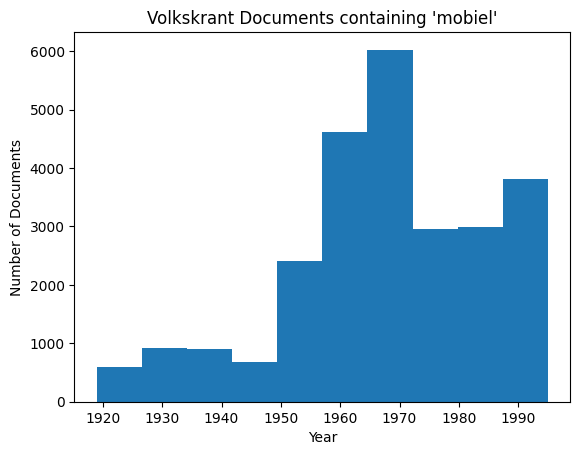

In [ ]:
plt.hist(volkskrant_term_rows.year)
plt.title(f"Volkskrant Documents containing '{TERM}'")
plt.xlabel("Year")
plt.ylabel("Number of Documents")


Text(0, 0.5, 'Number of Documents')

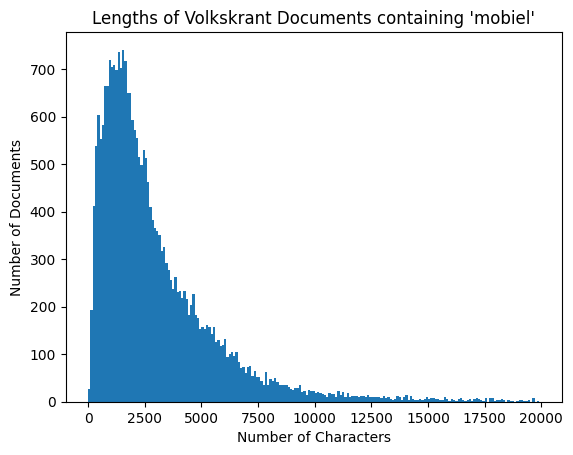

In [ ]:
plt.hist(volkskrant_term_rows.Content.str.len(), bins=range(0, 20000, 100))
plt.title(f"Lengths of Volkskrant Documents containing '{TERM}'")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Documents")

In [ ]:
for index, row in tqdm(
    volkskrant_term_rows.iterrows(), total=len(volkskrant_term_rows), unit="row"
):
    volkskrant_contexts.extend(
        Context.contexts(
            row.Content,
            TERM,
            MODEL_MAX_LENGTH,
            model,
            tokenizer,
            metadata={"date": row.date, "source": row.RecId},
        )
    )

print(f"Rows containing '{TERM}' in Volkskrant: {len(volkskrant_term_rows)}")
print(f"Contexts found for '{TERM}' in Volkskrant: {len(volkskrant_contexts)}")


100%|██████████| 25924/25924 [00:19<00:00, 1318.98row/s]

Rows containing 'mobiel' in Volkskrant: 25924
Contexts found for 'mobiel' in Volkskrant: 1521


## Merge and Sample

In [ ]:
from tqdm import tqdm
import random

SAMPLE_SIZE = 5000
RANDOM_SEED = 0

random.seed(RANDOM_SEED)

merged = anp_contexts + sg_contexts + volkskrant_contexts
#merged = volkskrant_contexts


if SAMPLE_SIZE is None or SAMPLE_SIZE > len(merged):
    sample = merged
else:
    sample = random.sample(merged, k=SAMPLE_SIZE)

print(f"Sample size: {len(sample)}")

Sample size: 3307


# Compute Embeddings

In [ ]:
# TODO: use batches for computing embeddings

token_embeddings = np.array(
    [
        context.token_embedding().detach().numpy()
        for context in tqdm(sample, unit="context")
    ]
)

assert token_embeddings.shape == (len(sample), model.config.hidden_size)


 42%|████▏     | 1401/3307 [06:40<08:40,  3.66context/s]

: 

: 

# Plot

In [ ]:
import umap.plot

umap.plot.output_notebook()

title = f"UMAP Embeddings Projections for '{TERM}'"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loading BokehJS ...

In [ ]:
mapper = umap.UMAP().fit(token_embeddings)


## Static

Text(0.5, 1.0, "UMAP Embeddings Projections for 'duurzaamheid'")

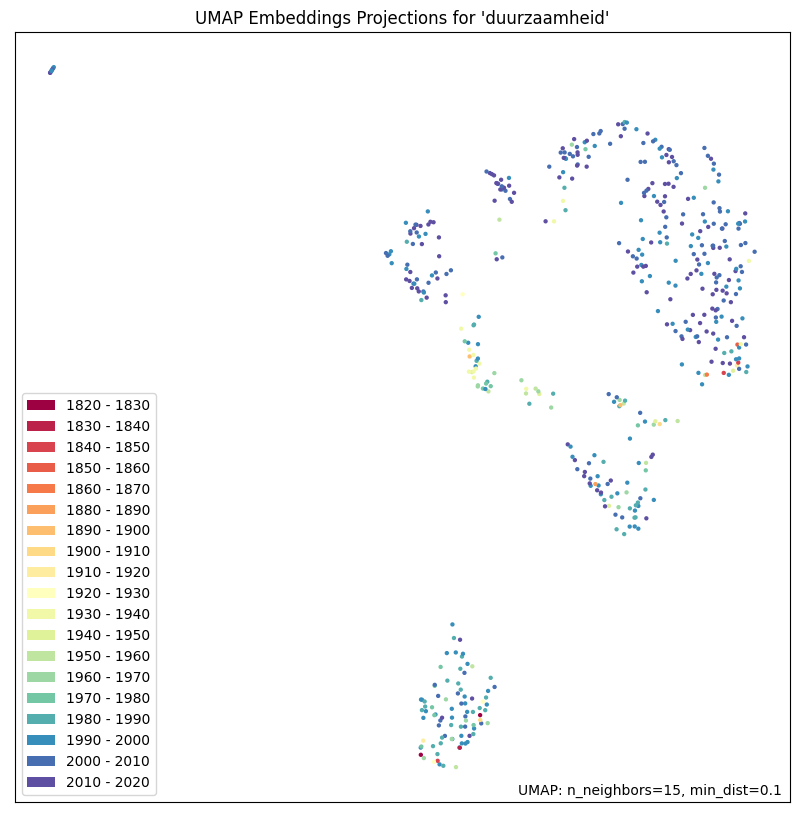

In [ ]:
labels = np.array([to_decade(context.metadata["date"]) for context in sample])
subplot = umap.plot.points(
    mapper,
    height=1000,
    width=1000,
    labels=labels
)
subplot.set_title(title)


## Interactive

In [ ]:
from bokeh.models import ColumnDataSource

metadatas = pd.DataFrame(
    [
        {
            "x": embedding[0],
            "y": embedding[1],
            "date": date_to_string(context.metadata["date"]),
            "source": context.metadata["source"],
            "decade": label,
            "context": context.text,
        }
        for context, embedding, label in zip(sample, mapper.embedding_, labels)
    ]
)
source = ColumnDataSource(data=metadatas)
metadatas


,x,y,date,source,decade,context
0,17.063086,6.782953,2008-11-06,h-tk-20082009-1645-1677,2000 - 2010,lan presenteren. Positief is dat de Commissie ...
1,14.569575,3.133602,1992-06-02,https://services.kb.nl/mdo/oai?verb=GetRecord&...,1990 - 2000,wij van mening. Het streven van het departeme...
2,10.682985,0.902189,1985-02-20,https://services.kb.nl/mdo/oai?verb=GetRecord&...,1980 - 1990,"ermindering van vervuiling, en het gebruik van..."
3,11.533623,7.565354,2010-04-20,h-ek-20092010-26-1080,2010 - 2020,sreactie daarop. Met de doelstellingen â sli...
4,15.498859,6.006427,1992-05-23,ddd:010866940:mpeg21:a0913,1990 - 2000,recteur van het Institute for Policy and Socia...
...,...,...,...,...,...,...
495,16.495859,5.275186,2011-12-14,h-tk-20112012-36-2,2010 - 2020,b dat er vrijhandelsakkoorden met dergelijke n...
496,12.862635,4.212769,1961-09-16,ddd:010877160:mpeg21:a0706,1960 - 1970,"n in de vorm van een trouweloos karakter, een ..."
497,17.150972,5.493475,1993-11-20,ddd:010866552:mpeg21:a0554,1990 - 2000,e werkloosheid schreeuwt om herverdeling van h...
498,1.659894,9.048366,1993-11-04,https://services.kb.nl/mdo/oai?verb=GetRecord&...,1990 - 2000,niet-project gerichte hulp. Bij de uitvoering ...


In [ ]:
from bokeh.plotting import figure, show

p = figure(
    height=1000,
    width=1000,
    tooltips=[("source", "@source"), ("date", "@date"), ("context", "@context")],
)
p.title = title


In [ ]:
from bokeh.palettes import d3
from bokeh.models import CategoricalColorMapper
import bokeh.palettes

categories = np.unique(labels)
palette = bokeh.palettes.inferno(len(categories))

assert len(palette) >= len(
    categories
), f"Palette has only {len(palette)} categories, but {len(categories)} needed."

color_mapper = CategoricalColorMapper(
    factors=[str(c) for c in categories], palette=palette
)
color_mapper


CategoricalColorMapper(id='1039', ...)

In [ ]:
from bokeh.models.tickers import SingleIntervalTicker
from bokeh.plotting import figure, show


# TODO: group by decade to enable muting decades individually via legend
p.dot(
    x="x",
    y="y",
    legend_field="decade",
    source=source,
    size=20,
    color={"field": "decade", "transform": color_mapper},
)

p.legend.click_policy = "mute"


p.xaxis.ticker = SingleIntervalTicker(desired_num_ticks=0)
p.yaxis.ticker = SingleIntervalTicker(desired_num_ticks=0)

show(p)
